# 1. Library Import

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc #garbage collection 감시
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
import seaborn as sns
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    min  = int(x[10:12])
    sec  = int(x[12:])
    return dt.datetime(year, month, day, hour,min,sec)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)
    
def string2num2(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    return int(x)
    
PATH = "Jupyter Temp/lg 공모전/data/"

In [3]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_qual  = pd.read_csv(PATH+'train_quality_data.csv')
train_prob  = pd.read_csv(PATH+'train_problem_data.csv')

In [4]:
display(train_err.head())
display(train_qual.head())
display(train_prob.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0


,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


In [5]:
del train_err["model_nm"]
del train_err["errcode"]

In [6]:
train_qual.drop_duplicates(keep="first",inplace=True)
train_qual.reset_index(drop=True,inplace=True)

In [7]:
train_qual.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,4,0,0,0,0,4,0,0
2,20201130210000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,8,0,0
3,20201130210000,10000,05.15.2138,0.0,0,0.0,0,0,8,0,0,0,0,8,0,0
4,20201104110000,10002,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,1,0,0,0


In [8]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284202 entries, 0 to 284201
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        284202 non-null  int64  
 1   user_id     284202 non-null  int64  
 2   fwver       272452 non-null  object 
 3   quality_0   247459 non-null  float64
 4   quality_1   284202 non-null  int64  
 5   quality_2   272419 non-null  float64
 6   quality_3   284202 non-null  int64  
 7   quality_4   284202 non-null  int64  
 8   quality_5   284187 non-null  object 
 9   quality_6   284202 non-null  int64  
 10  quality_7   284202 non-null  object 
 11  quality_8   284202 non-null  object 
 12  quality_9   284202 non-null  object 
 13  quality_10  284202 non-null  object 
 14  quality_11  284202 non-null  int64  
 15  quality_12  284202 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 34.7+ MB


<AxesSubplot:>

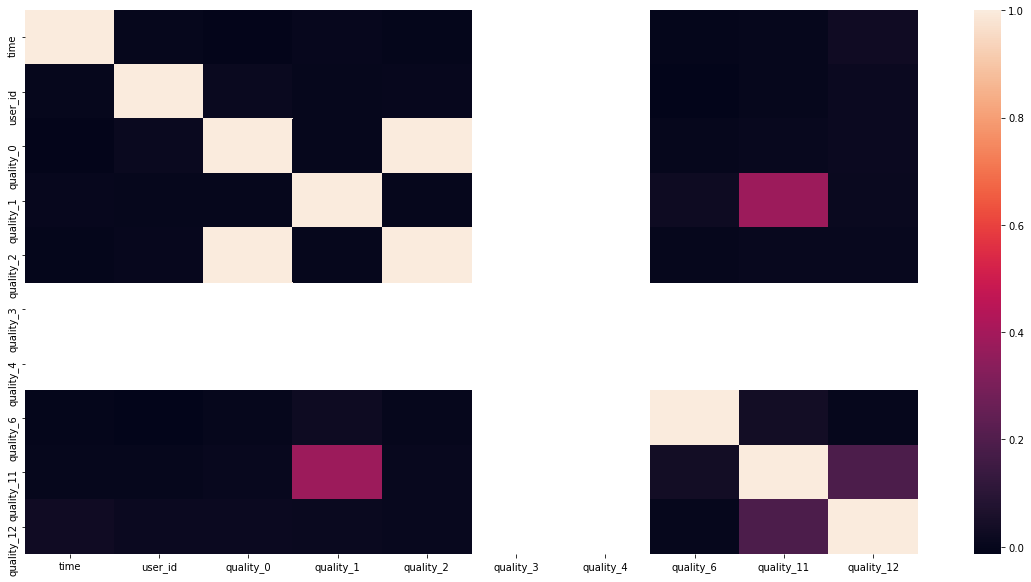

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(train_qual.corr())

In [10]:
quality_names = list(train_qual.columns)
quality_names.remove("time")
quality_names.remove("user_id")
quality_names.remove("fwver")

for i in quality_names:
  train_qual[i] = train_qual[i].apply(lambda x : string2num(x))

In [11]:
train_qual["quality_0_2"] = train_qual["quality_0"] - train_qual["quality_2"]
train_qual["quality_1_8"] = train_qual["quality_1"] - train_qual["quality_8"]
train_qual["quality_0_9"] = train_qual["quality_0"] - train_qual["quality_9"]
train_qual["quality_2_9"] = train_qual["quality_2"] - train_qual["quality_9"]
train_qual["quality_10_5"] = train_qual["quality_10"] - train_qual["quality_5"]
train_qual["quality_6_7"] = train_qual["quality_6"] - train_qual["quality_7"]

In [12]:
train_qual.columns

Index(['time', 'user_id', 'fwver', 'quality_0', 'quality_1', 'quality_2',
       'quality_3', 'quality_4', 'quality_5', 'quality_6', 'quality_7',
       'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12',
       'quality_0_2', 'quality_1_8', 'quality_0_9', 'quality_2_9',
       'quality_10_5', 'quality_6_7'],
      dtype='object')

In [13]:
quality_names = list(train_qual.columns)
quality_names.remove("time")
quality_names.remove("user_id")
quality_names.remove("fwver")

quality_names

['quality_0',
 'quality_1',
 'quality_2',
 'quality_3',
 'quality_4',
 'quality_5',
 'quality_6',
 'quality_7',
 'quality_8',
 'quality_9',
 'quality_10',
 'quality_11',
 'quality_12',
 'quality_0_2',
 'quality_1_8',
 'quality_0_9',
 'quality_2_9',
 'quality_10_5',
 'quality_6_7']

In [14]:
q_grouped = train_qual.groupby(["time","user_id","fwver"])

In [15]:
q_grouped

In [16]:
pd.DataFrame(q_grouped[quality_names[0]].max() - q_grouped[quality_names[0]].min()).to_csv("temp")
temp_1 = pd.read_csv("temp")
for i in quality_names[1:]:
  pd.DataFrame(q_grouped[i].max() - q_grouped[i].min()).to_csv("temp")
  temp_2 = pd.read_csv("temp")
  temp_1 = temp_1.merge(temp_2)

temp_1.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,...,quality_9,quality_10,quality_11,quality_12,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,20201031235000,10136,05.15.2138,10,1,10,0,0,2,1,...,0,0,1,0,0,1,10,10,2,1
1,20201031235000,12060,05.15.2138,10,1,10,0,0,4,1,...,0,0,1,0,0,1,10,10,4,1
2,20201031235000,12729,04.33.1185,10,4,10,0,0,1,1,...,0,0,1,0,0,4,10,10,1,1
3,20201031235000,13495,05.15.2138,10,1,10,0,0,7,1,...,0,0,1,0,0,1,10,10,7,1
4,20201031235000,13923,04.22.1750,0,0,0,0,0,3,10,...,0,0,0,0,0,0,0,0,3,10


In [17]:
train_change = temp_1.copy()
del q_grouped
del temp_1
del temp_2
del train_qual

In [18]:
train_change.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,...,quality_9,quality_10,quality_11,quality_12,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,20201031235000,10136,05.15.2138,10,1,10,0,0,2,1,...,0,0,1,0,0,1,10,10,2,1
1,20201031235000,12060,05.15.2138,10,1,10,0,0,4,1,...,0,0,1,0,0,1,10,10,4,1
2,20201031235000,12729,04.33.1185,10,4,10,0,0,1,1,...,0,0,1,0,0,4,10,10,1,1
3,20201031235000,13495,05.15.2138,10,1,10,0,0,7,1,...,0,0,1,0,0,1,10,10,7,1
4,20201031235000,13923,04.22.1750,0,0,0,0,0,3,10,...,0,0,0,0,0,0,0,0,3,10


In [19]:
train_change.sum()

time                                          1326809259421692000
user_id                                                1154876165
fwver           05.15.213805.15.213804.33.118505.15.213804.22....
quality_0                                                12637010
quality_1                                                   33393
quality_2                                                18322330
quality_3                                                       0
quality_4                                                       0
quality_5                                                24994897
quality_6                                                  495666
quality_7                                                       2
quality_8                                                       0
quality_9                                                       0
quality_10                                                      9
quality_11                                                  29661
quality_12

In [20]:
train_change.drop(columns=["quality_3","quality_4","quality_8","quality_9","quality_12"],inplace=True)

In [21]:
train_err.head()

,user_id,time,fwver,errtype
0,10000,20201101025616,05.15.2138,15
1,10000,20201101030309,05.15.2138,12
2,10000,20201101030309,05.15.2138,11
3,10000,20201101050514,05.15.2138,16
4,10000,20201101050515,05.15.2138,4


In [22]:
train_change.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,20201031235000,10136,05.15.2138,10,1,10,2,1,0,0,1,0,1,10,10,2,1
1,20201031235000,12060,05.15.2138,10,1,10,4,1,0,0,1,0,1,10,10,4,1
2,20201031235000,12729,04.33.1185,10,4,10,1,1,0,0,1,0,4,10,10,1,1
3,20201031235000,13495,05.15.2138,10,1,10,7,1,0,0,1,0,1,10,10,7,1
4,20201031235000,13923,04.22.1750,0,0,0,3,10,0,0,0,0,0,0,0,3,10


In [23]:
print(len(train_err))
print(len(train_change))

16554663
65680


In [24]:
train_err.sort_values(by="time",inplace=True)

In [25]:
train_change.sort_values(by="time",inplace=True)

In [26]:
train_err_chg_ = pd.merge_asof(train_err,train_change,on="time",by=["user_id","fwver"],direction="nearest")

In [27]:
train_err_chg_.head()

,user_id,time,fwver,errtype,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,15801,20201031235959,04.22.1750,16,10.0,1.0,10.0,2.0,303.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,303.0
1,22385,20201031235959,04.33.1185,26,10.0,1.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,3.0,1.0
2,22249,20201031235959,04.22.1750,26,10.0,1.0,10.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,1.0
3,18418,20201031235959,04.22.1750,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20974,20201031235959,04.22.1750,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
train_err_chg_.fillna(0,inplace=True)

In [29]:
train_err_chg_.head()

,user_id,time,fwver,errtype,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,15801,20201031235959,04.22.1750,16,10.0,1.0,10.0,2.0,303.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,303.0
1,22385,20201031235959,04.33.1185,26,10.0,1.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,3.0,1.0
2,22249,20201031235959,04.22.1750,26,10.0,1.0,10.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,1.0
3,18418,20201031235959,04.22.1750,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20974,20201031235959,04.22.1750,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
train_err_chg = train_err_chg_.copy()

del train_err_chg_
del train_err
del train_change

In [31]:
train_prob["label"] = 1

In [32]:
train_prob.sort_values(by="time",inplace=True)

In [33]:
train_prob.head()

,user_id,time,label
1084,18786,20201101000000,1
1455,21363,20201101010000,1
3192,14795,20201101010000,1
2488,17524,20201101010000,1
4925,11065,20201101020000,1


In [34]:
train_err_chg_prob_ = pd.merge_asof(train_err_chg,train_prob,on="time",by=["user_id"],direction="forward")
train_err_chg_prob = train_err_chg_prob_.copy()

del train_err_chg_prob_
del train_err_chg
del train_prob

In [35]:
del train_err_chg_prob["time"]

In [36]:
train_err_chg_prob.fillna(0,inplace=True)

In [37]:
train_err_chg_prob.head()

,user_id,fwver,errtype,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7,label
0,15801,04.22.1750,16,10.0,1.0,10.0,2.0,303.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,303.0,1.0
1,22385,04.33.1185,26,10.0,1.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,3.0,1.0,1.0
2,22249,04.22.1750,26,10.0,1.0,10.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,1.0,1.0
3,18418,04.22.1750,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20974,04.22.1750,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
del train_err_chg_prob["fwver"]

In [39]:
train_err_chg_prob = pd.get_dummies(train_err_chg_prob,columns = ["errtype"])

In [40]:
train_xy = pd.DataFrame({"user_id":train_err_chg_prob["user_id"].unique()})
train_xy.sort_values(by="user_id",inplace=True)

In [41]:
train_err_chg_prob.sort_values(by="user_id",inplace=True)

In [42]:
train_err_chg_prob.head()

,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,...,errtype_33,errtype_34,errtype_35,errtype_36,errtype_37,errtype_38,errtype_39,errtype_40,errtype_41,errtype_42
107051,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7717972,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6639773,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8587017,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8587010,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
train_xy.reset_index(drop=True,inplace=True)
train_err_chg_prob.reset_index(drop=True,inplace=True)

In [44]:
train_xy

,user_id
0,10000
1,10001
2,10002
3,10003
4,10004
...,...
14995,24995
14996,24996
14997,24997
14998,24998


In [45]:
for i in train_err_chg_prob.columns[1:]:
    train_xy[i] = list(train_err_chg_prob[["user_id",i]].groupby(by="user_id").sum()[i])

In [46]:
train_xy.head()

,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,...,errtype_33,errtype_34,errtype_35,errtype_36,errtype_37,errtype_38,errtype_39,errtype_40,errtype_41,errtype_42
0,10000,0.0,0.0,0.0,1304.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0
1,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,18.0,0.0,1,1,0,0.0,113.0,56.0,1
2,10002,1200.0,14.0,670.0,863.0,2479.0,0.0,0.0,14.0,530.0,...,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0
3,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,0.0,0.0,1,1,2,0.0,17.0,1.0,0
4,10004,570.0,57.0,570.0,702.0,51213.0,0.0,0.0,57.0,0.0,...,16,0.0,0.0,1,1,0,0.0,4.0,0.0,2


In [47]:
del train_err_chg_prob

In [48]:
train_xy["label"] = np.where(train_xy["label"]>0,1,0)

In [49]:
train_xy

,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,...,errtype_33,errtype_34,errtype_35,errtype_36,errtype_37,errtype_38,errtype_39,errtype_40,errtype_41,errtype_42
0,10000,0.0,0.0,0.0,1304.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0
1,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,18.0,0.0,1,1,0,0.0,113.0,56.0,1
2,10002,1200.0,14.0,670.0,863.0,2479.0,0.0,0.0,14.0,530.0,...,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0
3,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,0.0,0.0,1,1,2,0.0,17.0,1.0,0
4,10004,570.0,57.0,570.0,702.0,51213.0,0.0,0.0,57.0,0.0,...,16,0.0,0.0,1,1,0,0.0,4.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24995,1940.0,194.0,1940.0,427.0,194.0,0.0,0.0,194.0,0.0,...,5,0.0,0.0,0,0,0,0.0,9.0,7.0,4
14996,24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0
14997,24997,4650.0,465.0,4650.0,4179.0,465.0,0.0,0.0,465.0,0.0,...,16,17.0,0.0,1,1,0,0.0,58.0,8.0,5
14998,24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15,12.0,0.0,1,1,0,0.0,6.0,0.0,0


In [50]:
train_xy.to_csv("Jupyter Temp/lg 공모전/model sets/train_xy.csv",index=False)

# Test set

In [51]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
test_qual  = pd.read_csv(PATH+'test_quality_data.csv')

In [52]:
test_err.shape

(16532648, 6)

In [55]:
set(test_qual["user_id"])-set(test_err["user_id"])

{43262}

In [3]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_qual  = pd.read_csv(PATH+'train_quality_data.csv')
train_prob  = pd.read_csv(PATH+'train_problem_data.csv')

In [4]:
display(train_err.head())
display(train_qual.head())
display(train_prob.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0


,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


In [5]:
del train_err["model_nm"]
del train_err["errcode"]

In [6]:
train_qual.drop_duplicates(keep="first",inplace=True)
train_qual.reset_index(drop=True,inplace=True)

In [7]:
train_qual.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,4,0,0,0,0,4,0,0
2,20201130210000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,8,0,0
3,20201130210000,10000,05.15.2138,0.0,0,0.0,0,0,8,0,0,0,0,8,0,0
4,20201104110000,10002,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,1,0,0,0


In [8]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284202 entries, 0 to 284201
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        284202 non-null  int64  
 1   user_id     284202 non-null  int64  
 2   fwver       272452 non-null  object 
 3   quality_0   247459 non-null  float64
 4   quality_1   284202 non-null  int64  
 5   quality_2   272419 non-null  float64
 6   quality_3   284202 non-null  int64  
 7   quality_4   284202 non-null  int64  
 8   quality_5   284187 non-null  object 
 9   quality_6   284202 non-null  int64  
 10  quality_7   284202 non-null  object 
 11  quality_8   284202 non-null  object 
 12  quality_9   284202 non-null  object 
 13  quality_10  284202 non-null  object 
 14  quality_11  284202 non-null  int64  
 15  quality_12  284202 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 34.7+ MB


<AxesSubplot:>

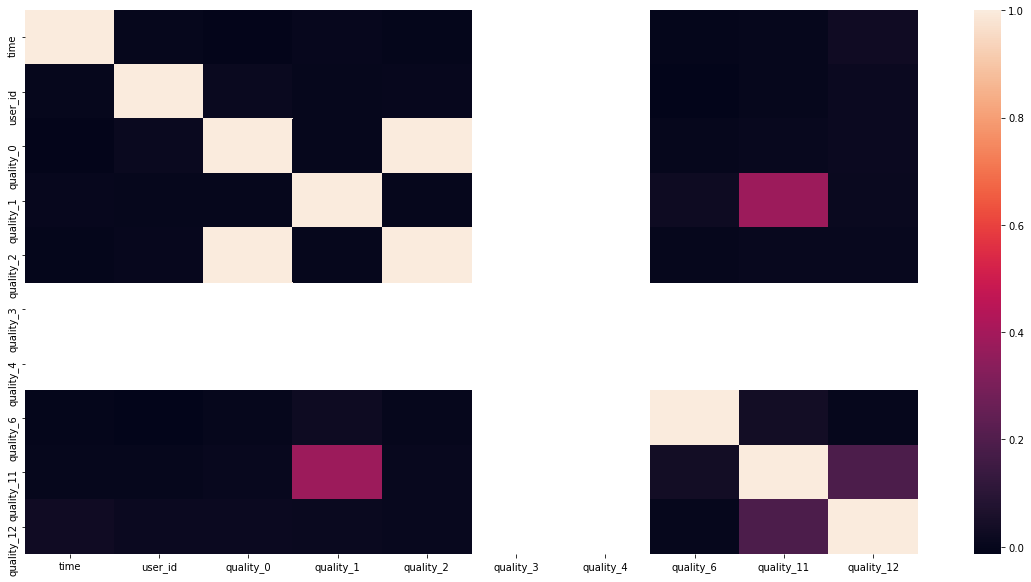

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(train_qual.corr())

In [10]:
quality_names = list(train_qual.columns)
quality_names.remove("time")
quality_names.remove("user_id")
quality_names.remove("fwver")

for i in quality_names:
  train_qual[i] = train_qual[i].apply(lambda x : string2num(x))

In [11]:
train_qual["quality_0_2"] = train_qual["quality_0"] - train_qual["quality_2"]
train_qual["quality_1_8"] = train_qual["quality_1"] - train_qual["quality_8"]
train_qual["quality_0_9"] = train_qual["quality_0"] - train_qual["quality_9"]
train_qual["quality_2_9"] = train_qual["quality_2"] - train_qual["quality_9"]
train_qual["quality_10_5"] = train_qual["quality_10"] - train_qual["quality_5"]
train_qual["quality_6_7"] = train_qual["quality_6"] - train_qual["quality_7"]

In [12]:
train_qual.columns

Index(['time', 'user_id', 'fwver', 'quality_0', 'quality_1', 'quality_2',
       'quality_3', 'quality_4', 'quality_5', 'quality_6', 'quality_7',
       'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12',
       'quality_0_2', 'quality_1_8', 'quality_0_9', 'quality_2_9',
       'quality_10_5', 'quality_6_7'],
      dtype='object')

In [13]:
quality_names = list(train_qual.columns)
quality_names.remove("time")
quality_names.remove("user_id")
quality_names.remove("fwver")

quality_names

['quality_0',
 'quality_1',
 'quality_2',
 'quality_3',
 'quality_4',
 'quality_5',
 'quality_6',
 'quality_7',
 'quality_8',
 'quality_9',
 'quality_10',
 'quality_11',
 'quality_12',
 'quality_0_2',
 'quality_1_8',
 'quality_0_9',
 'quality_2_9',
 'quality_10_5',
 'quality_6_7']

In [14]:
q_grouped = train_qual.groupby(["time","user_id","fwver"])

In [15]:
q_grouped

In [16]:
pd.DataFrame(q_grouped[quality_names[0]].max() - q_grouped[quality_names[0]].min()).to_csv("temp")
temp_1 = pd.read_csv("temp")
for i in quality_names[1:]:
  pd.DataFrame(q_grouped[i].max() - q_grouped[i].min()).to_csv("temp")
  temp_2 = pd.read_csv("temp")
  temp_1 = temp_1.merge(temp_2)

temp_1.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,...,quality_9,quality_10,quality_11,quality_12,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,20201031235000,10136,05.15.2138,10,1,10,0,0,2,1,...,0,0,1,0,0,1,10,10,2,1
1,20201031235000,12060,05.15.2138,10,1,10,0,0,4,1,...,0,0,1,0,0,1,10,10,4,1
2,20201031235000,12729,04.33.1185,10,4,10,0,0,1,1,...,0,0,1,0,0,4,10,10,1,1
3,20201031235000,13495,05.15.2138,10,1,10,0,0,7,1,...,0,0,1,0,0,1,10,10,7,1
4,20201031235000,13923,04.22.1750,0,0,0,0,0,3,10,...,0,0,0,0,0,0,0,0,3,10


In [17]:
train_change = temp_1.copy()
del q_grouped
del temp_1
del temp_2
del train_qual

In [18]:
train_change.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,...,quality_9,quality_10,quality_11,quality_12,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,20201031235000,10136,05.15.2138,10,1,10,0,0,2,1,...,0,0,1,0,0,1,10,10,2,1
1,20201031235000,12060,05.15.2138,10,1,10,0,0,4,1,...,0,0,1,0,0,1,10,10,4,1
2,20201031235000,12729,04.33.1185,10,4,10,0,0,1,1,...,0,0,1,0,0,4,10,10,1,1
3,20201031235000,13495,05.15.2138,10,1,10,0,0,7,1,...,0,0,1,0,0,1,10,10,7,1
4,20201031235000,13923,04.22.1750,0,0,0,0,0,3,10,...,0,0,0,0,0,0,0,0,3,10


In [19]:
train_change.sum()

time                                          1326809259421692000
user_id                                                1154876165
fwver           05.15.213805.15.213804.33.118505.15.213804.22....
quality_0                                                12637010
quality_1                                                   33393
quality_2                                                18322330
quality_3                                                       0
quality_4                                                       0
quality_5                                                24994897
quality_6                                                  495666
quality_7                                                       2
quality_8                                                       0
quality_9                                                       0
quality_10                                                      9
quality_11                                                  29661
quality_12

In [20]:
train_change.drop(columns=["quality_3","quality_4","quality_8","quality_9","quality_12"],inplace=True)

In [21]:
train_err.head()

,user_id,time,fwver,errtype
0,10000,20201101025616,05.15.2138,15
1,10000,20201101030309,05.15.2138,12
2,10000,20201101030309,05.15.2138,11
3,10000,20201101050514,05.15.2138,16
4,10000,20201101050515,05.15.2138,4


In [22]:
train_change.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,20201031235000,10136,05.15.2138,10,1,10,2,1,0,0,1,0,1,10,10,2,1
1,20201031235000,12060,05.15.2138,10,1,10,4,1,0,0,1,0,1,10,10,4,1
2,20201031235000,12729,04.33.1185,10,4,10,1,1,0,0,1,0,4,10,10,1,1
3,20201031235000,13495,05.15.2138,10,1,10,7,1,0,0,1,0,1,10,10,7,1
4,20201031235000,13923,04.22.1750,0,0,0,3,10,0,0,0,0,0,0,0,3,10


In [23]:
print(len(train_err))
print(len(train_change))

16554663
65680


In [24]:
train_err.sort_values(by="time",inplace=True)

In [25]:
train_change.sort_values(by="time",inplace=True)

In [26]:
train_err_chg_ = pd.merge_asof(train_err,train_change,on="time",by=["user_id","fwver"],direction="nearest")

In [27]:
train_err_chg_.head()

,user_id,time,fwver,errtype,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,15801,20201031235959,04.22.1750,16,10.0,1.0,10.0,2.0,303.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,303.0
1,22385,20201031235959,04.33.1185,26,10.0,1.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,3.0,1.0
2,22249,20201031235959,04.22.1750,26,10.0,1.0,10.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,1.0
3,18418,20201031235959,04.22.1750,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20974,20201031235959,04.22.1750,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
train_err_chg_.fillna(0,inplace=True)

In [29]:
train_err_chg_.head()

,user_id,time,fwver,errtype,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7
0,15801,20201031235959,04.22.1750,16,10.0,1.0,10.0,2.0,303.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,303.0
1,22385,20201031235959,04.33.1185,26,10.0,1.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,3.0,1.0
2,22249,20201031235959,04.22.1750,26,10.0,1.0,10.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,1.0
3,18418,20201031235959,04.22.1750,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20974,20201031235959,04.22.1750,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
train_err_chg = train_err_chg_.copy()

del train_err_chg_
del train_err
del train_change

In [31]:
train_prob["label"] = 1

In [32]:
train_prob.sort_values(by="time",inplace=True)

In [33]:
train_prob.head()

,user_id,time,label
1084,18786,20201101000000,1
1455,21363,20201101010000,1
3192,14795,20201101010000,1
2488,17524,20201101010000,1
4925,11065,20201101020000,1


In [34]:
train_err_chg_prob_ = pd.merge_asof(train_err_chg,train_prob,on="time",by=["user_id"],direction="forward")
train_err_chg_prob = train_err_chg_prob_.copy()

del train_err_chg_prob_
del train_err_chg
del train_prob

In [35]:
del train_err_chg_prob["time"]

In [36]:
train_err_chg_prob.fillna(0,inplace=True)

In [37]:
train_err_chg_prob.head()

,user_id,fwver,errtype,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,quality_1_8,quality_0_9,quality_2_9,quality_10_5,quality_6_7,label
0,15801,04.22.1750,16,10.0,1.0,10.0,2.0,303.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,303.0,1.0
1,22385,04.33.1185,26,10.0,1.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,3.0,1.0,1.0
2,22249,04.22.1750,26,10.0,1.0,10.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,10.0,2.0,1.0,1.0
3,18418,04.22.1750,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20974,04.22.1750,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
del train_err_chg_prob["fwver"]

In [39]:
train_err_chg_prob = pd.get_dummies(train_err_chg_prob,columns = ["errtype"])

In [40]:
train_xy = pd.DataFrame({"user_id":train_err_chg_prob["user_id"].unique()})
train_xy.sort_values(by="user_id",inplace=True)

In [41]:
train_err_chg_prob.sort_values(by="user_id",inplace=True)

In [42]:
train_err_chg_prob.head()

,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_10,quality_11,quality_0_2,...,errtype_33,errtype_34,errtype_35,errtype_36,errtype_37,errtype_38,errtype_39,errtype_40,errtype_41,errtype_42
107051,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7717972,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6639773,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8587017,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8587010,10000,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
train_xy.reset_index(drop=True,inplace=True)
train_err_chg_prob.reset_index(drop=True,inplace=True)

In [44]:
train_xy

,user_id
0,10000
1,10001
2,10002
3,10003
4,10004
...,...
14995,24995
14996,24996
14997,24997
14998,24998


In [ ]:
for i in train_err_chg_prob.columns[1:]:
    train_xy[i] = list(train_err_chg_prob[["user_id",i]].groupby(by="user_id").sum()[i])

In [ ]:
train_xy.head()

In [ ]:
del train_err_chg_prob

In [ ]:
train_xy["label"] = np.where(train_xy["label"]>0,1,0)

In [ ]:
train_xy

In [ ]:
train_xy.to_csv("Jupyter Temp/lg 공모전/model sets/train_xy.csv",index=False)